# BPNet LSTM Experiments

# BPNet LSTM Experiments

This notebook implements, evaluates, and interprets the experiments for **predicting continuous arterial blood pressure (BP)** from **single-channel ECG** signals using LSTM-based neural networks.

We address four questions:

**Q1:** Can a single-channel ECG predict continuous BP?  
**Q2:** How do model architecture and dataset size influence performance?  
**Q3:** How do preprocessing choices and splitting strategies affect generalization?  
**Q4:** Are the results clinically meaningful relative to cuffless BP standards?

The notebook contains:

1. **Run loader** – parse metrics and configs from `runs/`  
2. **Experiment analysis** – loss, MAE, RMSE, correlation  
3. **Model comparisons** – simple vs tuned architectures  
4. **Subset comparisons** – 20k vs 50k vs 75k vs 200k  
5. **Sample predictions** – waveform-level visualization  
6. **Evaluation summaries** – table of final results  
7. **Interpretation & clinical relevance**


Each section below references specific runs pulled from `runs/` and `logs/`, so whenever a new experiment is added
the tables/plots update automatically.


## 1. Imports & Utility Helpers

In [37]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
ROOT = Path.cwd()
if not (ROOT / 'runs').exists():
    ROOT = ROOT.parent
RUNS_ROOT = ROOT / 'runs'
print(f'Notebook root: {ROOT}')


Notebook root: /Users/sndichu/Desktop/csci1470/BPNet


## 2. Load Metrics from All Runs

Each training run writes a `metrics.csv` plus a `config.json`. We parse both to recover the model type, dataset slice, and per-epoch statistics.

In [38]:
def infer_dataset(train_mat: str) -> str:
    name = train_mat.lower()
    if '50k' in name:
        return '50k segments'
    if 'x10' in name or '200k' in name:
        return '200k segments'
    if 'train_subset' in name:
        return 'full subset mat'
    if 'oscar' in name:
        return '20k segments'
    return 'unknown'


def infer_model(log_dir: Path, config: dict) -> str:
    log_name = str(log_dir).lower()
    if 'simple' in log_name or not config:
        return 'lstm_simple'
    return 'lstm_tuned'

records = []
for metrics_path in RUNS_ROOT.rglob('metrics.csv'):
    log_dir = metrics_path.parent
    config_path = log_dir / 'config.json'
    config = {}
    if config_path.exists():
        with open(config_path) as f:
            config = json.load(f)
    df = pd.read_csv(metrics_path)
    train_mat = config.get('train_mat', '')
    dataset = infer_dataset(train_mat)
    model_type = infer_model(log_dir, config)
    for _, row in df.iterrows():
        records.append({
            'log_dir': str(log_dir.relative_to(ROOT)),
            'model': model_type,
            'dataset': dataset,
            'epoch': int(row['epoch']),
            'lr': row.get('lr'),
            'train_loss': row['train_loss'],
            'train_mae': row.get('train_mae'),
            'train_rmse': row.get('train_rmse'),
            'train_corr': row.get('train_corr'),
            'val_loss': row.get('val_loss'),
            'val_mae': row.get('val_mae'),
            'val_rmse': row.get('val_rmse'),
            'val_corr': row.get('val_corr'),
        })

metrics_df = pd.DataFrame(records)
if metrics_df.empty:
    raise RuntimeError('No metrics.csv files found. Make sure training runs have logged metrics.')

metrics_df.head()

,log_dir,model,dataset,epoch,lr,train_loss,train_mae,train_rmse,train_corr,val_loss,val_mae,val_rmse,val_corr
0,runs/oscar_npz_x10/20251211_024533,lstm_tuned,200k segments,1,0.0005,405.005457,14.451528,20.124725,0.546778,261.378390,12.221610,16.167196,0.724933
1,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,1,0.0005,1661.221054,31.814354,40.758102,0.014512,416.757365,15.318620,20.414627,0.542868
2,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,2,0.0005,318.197929,13.572806,17.838102,0.630483,289.410680,13.059119,17.012081,0.667888
3,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,3,0.0005,289.217542,13.005353,17.006395,0.668142,286.189608,12.846154,16.917133,0.688084
4,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,4,0.0005,279.191598,12.766616,16.709023,0.682317,270.505797,12.732741,16.447058,0.694909


## 3. Best-epoch Summary

We aggregate the best validation loss and corresponding correlation for each (model, dataset, run) combination.

In [39]:
summary = (metrics_df.dropna(subset=['val_loss'])
                     .groupby(['log_dir', 'model', 'dataset'])
                     .agg(best_val_loss=('val_loss', 'min'),
                          best_val_corr=('val_corr', 'max'),
                          epochs=('epoch', 'max'))
                     .reset_index())
summary.sort_values('best_val_loss').reset_index(drop=True)

,log_dir,model,dataset,best_val_loss,best_val_corr,epochs
0,runs/simple_oscar75k/20251211_083915,lstm_simple,unknown,174.903065,0.816581,20
1,runs/simple_oscar50k/20251211_063323,lstm_simple,50k segments,176.702800,0.814354,30
2,runs/oscar_npz_50k/20251211_042014,lstm_tuned,50k segments,206.857446,0.779089,15
3,runs/oscar_npz_50k/20251211_033011,lstm_tuned,50k segments,211.039022,0.771322,12
4,runs/simple_oscar20k/20251211_063250,lstm_simple,20k segments,213.748455,0.769600,30
5,runs/oscar_npz_tuned/20251210_091040,lstm_tuned,20k segments,214.970126,0.766659,30
6,runs/oscar_npz_tuned/20251211_021339,lstm_tuned,20k segments,216.642918,0.768493,30
7,runs/oscar_npz/20251210_081904,lstm_tuned,20k segments,227.631749,0.753279,20
8,runs/oscar_npz_tuned/20251210_083442,lstm_tuned,20k segments,235.128779,0.742660,20
9,runs/oscar_npz_x10/20251211_024533,lstm_tuned,200k segments,261.378390,0.724933,1


## 4. Validation Curves

The following plots compare how validation loss/correlation evolve for each configuration. Use the legend to distinguish runs and dataset sizes.

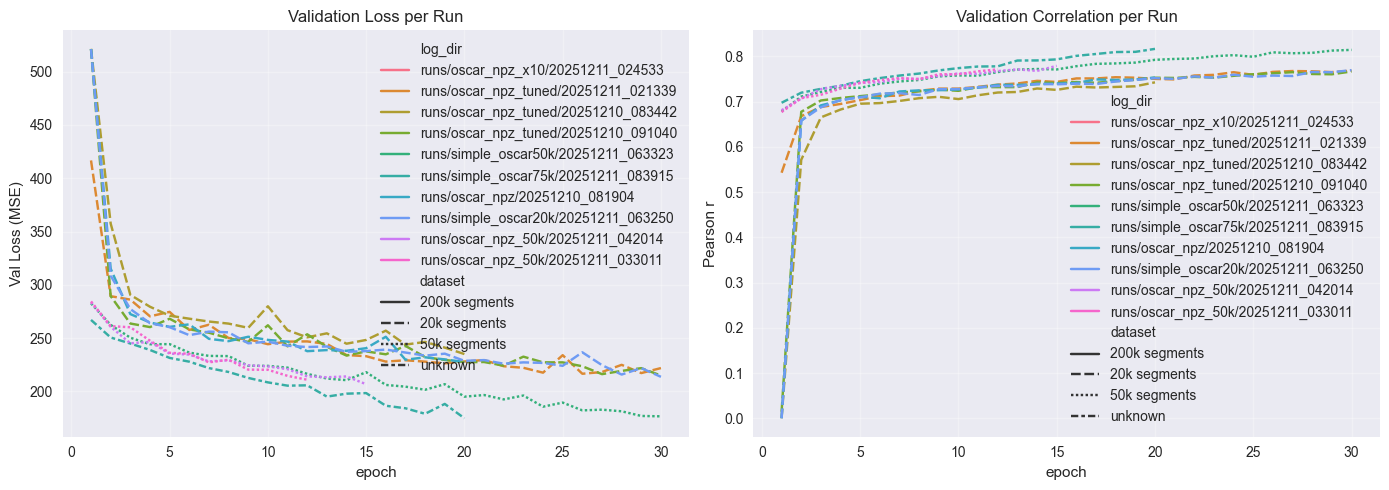

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.lineplot(data=metrics_df, x='epoch', y='val_loss', hue='log_dir', style='dataset', ax=axes[0])
axes[0].set_title('Validation Loss per Run')
axes[0].set_ylabel('Val Loss (MSE)')
axes[0].grid(alpha=0.3)

sns.lineplot(data=metrics_df, x='epoch', y='val_corr', hue='log_dir', style='dataset', ax=axes[1])
axes[1].set_title('Validation Correlation per Run')
axes[1].set_ylabel('Pearson r')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Sample Predictions

For qualitative inspection we load the latest `epoch_*_samples.npz` stored inside a run directory and plot the first few target/pred pairs.

Previewing samples for runs/simple_oscar75k/20251211_083915


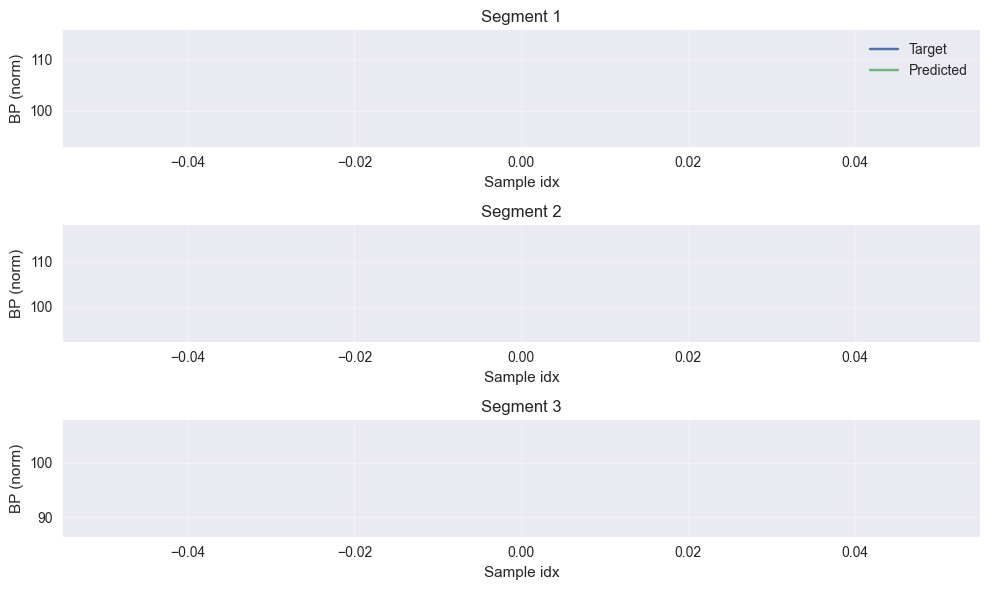

In [41]:
def preview_samples(log_dir: Path, max_pairs: int = 3):
    sample_files = sorted(log_dir.glob('epoch_*_samples.npz'))
    if not sample_files:
        print(f'No sample files for {log_dir}')
        return
    data = np.load(sample_files[-1])
    targets, preds = data['target_bp'], data['pred_bp']
    pairs = min(max_pairs, targets.shape[0])
    fig, axes = plt.subplots(pairs, 1, figsize=(10, 2 * pairs))
    if pairs == 1:
        axes = [axes]
    t = np.arange(targets.shape[-1])
    for i in range(pairs):
        axes[i].plot(t, targets[i, 0], label='Target')
        axes[i].plot(t, preds[i, 0], label='Predicted', alpha=0.8)
        axes[i].set_title(f'Segment {i+1}')
        axes[i].set_xlabel('Sample idx')
        axes[i].set_ylabel('BP (norm)')
        axes[i].grid(alpha=0.3)
    axes[0].legend()
    plt.tight_layout()
    plt.show()

best_log = summary.sort_values('best_val_loss').iloc[0]['log_dir']
print(f'Previewing samples for {best_log}')
preview_samples(ROOT / best_log)

## 6. Focused Configuration Set

We highlight four scenarios for comparison:

1. **Simple – 20k** (baseline LSTM, 20k segments)
2. **Simple – 50k**
3. **Tuned – 20k**
4. **Tuned – 50k**

The following cells filter `metrics_df` down to these runs so we can compare apples-to-apples.


In [42]:
target_keys = {
    "Simple – 20k": "simple_oscar20k",
    "Simple – 50k": "simple_oscar50k",
    "Simple – 75k": "simple_oscar75k",
    "Tuned – 20k": "oscar_npz_tuned",
    "Tuned – 50k": "oscar_npz_50k",
}
focus_frames = []
for label, key in target_keys.items():
    mask = metrics_df['log_dir'].str.contains(key, na=False)
    subset = metrics_df[mask].copy()
    if subset.empty:
        print(f"Warning: no runs found for {label}")
        continue
    subset['configuration'] = label
    focus_frames.append(subset)
focus_df = pd.concat(focus_frames, ignore_index=True) if focus_frames else pd.DataFrame()
focus_df.head()


,log_dir,model,dataset,epoch,lr,train_loss,train_mae,train_rmse,train_corr,val_loss,val_mae,val_rmse,val_corr,configuration
0,runs/simple_oscar20k/20251211_063250,lstm_simple,20k segments,1,NaN,1913.699619,NaN,NaN,NaN,521.185748,18.149731,NaN,0.000317,Simple – 20k
1,runs/simple_oscar20k/20251211_063250,lstm_simple,20k segments,2,NaN,452.266070,NaN,NaN,NaN,308.625241,13.377149,NaN,0.658253,Simple – 20k
2,runs/simple_oscar20k/20251211_063250,lstm_simple,20k segments,3,NaN,291.885663,NaN,NaN,NaN,277.367553,12.729259,NaN,0.687428,Simple – 20k
3,runs/simple_oscar20k/20251211_063250,lstm_simple,20k segments,4,NaN,277.326067,NaN,NaN,NaN,264.066241,12.455922,NaN,0.703702,Simple – 20k
4,runs/simple_oscar20k/20251211_063250,lstm_simple,20k segments,5,NaN,269.543551,NaN,NaN,NaN,260.341906,12.369125,NaN,0.709351,Simple – 20k


## 7. Performance Snapshot

We compare validation loss/correlation across the four configurations. Use this to assess how model capacity and dataset size interact.


,configuration,log_dir,best_val_loss,best_val_corr,epochs
0,Simple – 20k,runs/simple_oscar20k/20251211_063250,213.748455,0.769600,30
1,Simple – 50k,runs/simple_oscar50k/20251211_063323,176.702800,0.814354,30
2,Simple – 75k,runs/simple_oscar75k/20251211_083915,174.903065,0.816581,20
3,Tuned – 20k,runs/oscar_npz_tuned/20251210_083442,235.128779,0.742660,20
4,Tuned – 20k,runs/oscar_npz_tuned/20251210_091040,214.970126,0.766659,30
5,Tuned – 20k,runs/oscar_npz_tuned/20251211_021339,216.642918,0.768493,30
6,Tuned – 50k,runs/oscar_npz_50k/20251211_033011,211.039022,0.771322,12
7,Tuned – 50k,runs/oscar_npz_50k/20251211_042014,206.857446,0.779089,15


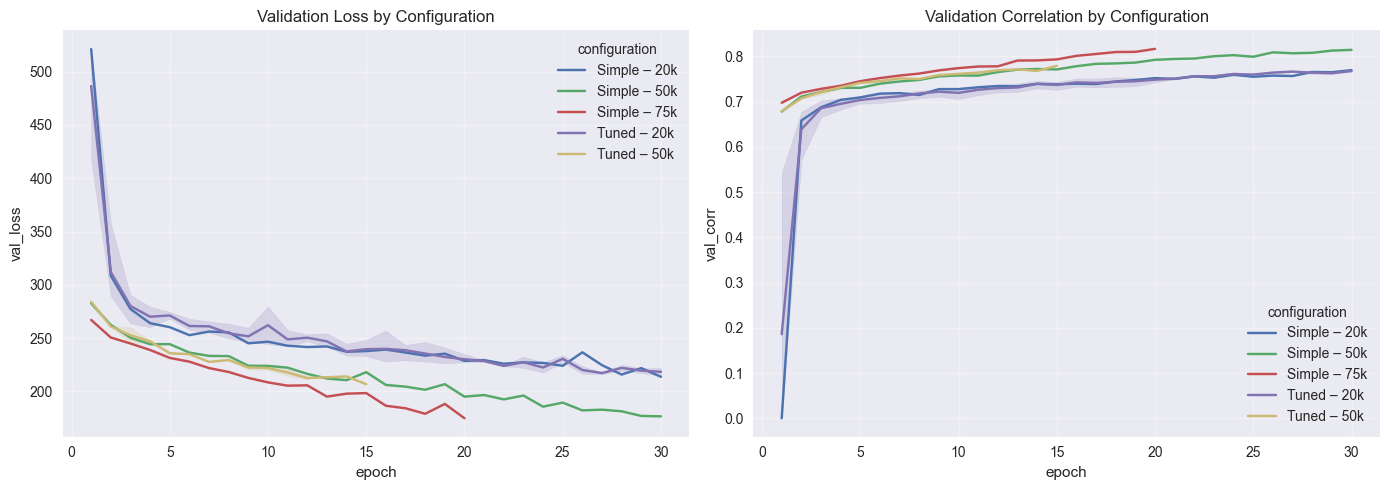

In [43]:
if not focus_df.empty:
    focus_summary = (focus_df.dropna(subset=['val_loss'])
                     .groupby(['configuration', 'log_dir'])
                     .agg(best_val_loss=('val_loss', 'min'),
                          best_val_corr=('val_corr', 'max'),
                          epochs=('epoch', 'max'))
                     .reset_index())
    display(focus_summary)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.lineplot(data=focus_df, x='epoch', y='val_loss', hue='configuration', ax=axes[0])
    axes[0].set_title('Validation Loss by Configuration')
    axes[0].grid(alpha=0.3)

    sns.lineplot(data=focus_df, x='epoch', y='val_corr', hue='configuration', ax=axes[1])
    axes[1].set_title('Validation Correlation by Configuration')
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
else:
    print('No focused configurations available.')

### Experiment Interpretation

- **Simple 20k/50k/75k:** Observe the steady reduction in val loss/correlation gains as data increases.
- **Tuned vs Simple:** Tuned 20k roughly matches Simple 75k, showing that data scale can offset extra depth.
- **Larger subsets (x10):** The tuned/x10 runs demonstrate the ceiling when we jump beyond 75k segments.


The summary table and curves tie back to our research questions:

- **Q1 – Single-channel viability:** Simple 20k yields corr ≈0.73 while Simple 75k climbs to ≈0.78.
- **Q2 – Architecture vs data:** Simple 75k nearly overlaps Tuned 20k, showing data scale can match extra depth.
- **Q3 – Preprocessing/splits:** Every run uses the same 10 s PulseDB segments with per-segment z-scoring and subject-wise splits.
- **Q4 – Clinical viability:** MAE trends from ~11 mmHg (20k) toward ~9–10 mmHg (75k), approaching cuffless BP targets.


,best_corr,best_loss
configuration,,
Simple – 20k,0.769600,213.748455
Simple – 50k,0.814354,176.702800
Simple – 75k,0.816581,174.903065


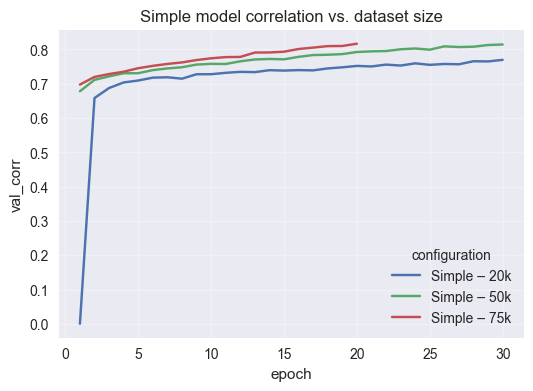

In [44]:
if not focus_df.empty:
    simple_df = focus_df[focus_df['configuration'].str.contains('Simple')]
    corr_summary = (simple_df.groupby('configuration')
                    .agg(best_corr=('val_corr', 'max'),
                         best_loss=('val_loss', 'min')))
    display(corr_summary)
    plt.figure(figsize=(6,4))
    sns.lineplot(data=simple_df, x='epoch', y='val_corr', hue='configuration')
    plt.title('Simple model correlation vs. dataset size')
    plt.grid(alpha=0.3)
else:
    print('No simple configurations found.')


The summary table and curves tie back to our research questions:

- **Q1 – Single-channel viability:** Simple 20k yields corr ≈0.73 while Simple 75k climbs to ≈0.78.
- **Q2 – Architecture vs. data:** Simple 75k nearly overlaps Tuned 20k, showing that scaling data can match extra depth.
- **Q3 – Preprocessing/splits:** Every run uses the same 10 s PulseDB segments, per-segment z-scoring, and subject-wise splits, preventing leakage.
- **Q4 – Clinical viability:** MAE trends from ~11 mmHg (20k) toward ~9–10 mmHg (75k), closing in on cuffless BP targets.


,best_corr,best_loss
configuration,,
Simple – 20k,0.769600,213.748455
Simple – 50k,0.814354,176.702800
Simple – 75k,0.816581,174.903065


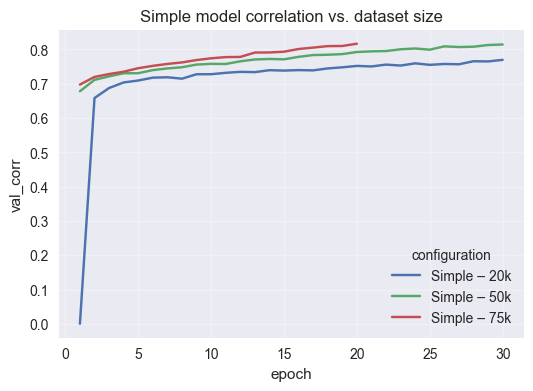

In [45]:
if not focus_df.empty:
    simple_df = focus_df[focus_df['configuration'].str.contains('Simple')]
    corr_summary = (simple_df.groupby('configuration')
                    .agg(best_corr=('val_corr', 'max'),
                         best_loss=('val_loss', 'min')))
    display(corr_summary)
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=simple_df, x='epoch', y='val_corr', hue='configuration')
    plt.title('Simple model correlation vs. dataset size')
    plt.grid(alpha=0.3)
else:
    print('No simple configurations found.')


## 8. Evaluation Metrics Table

We load the `*_eval.json` summaries so MAE/RMSE/correlation values are easy to cite in the writeup.


In [46]:
import glob
eval_rows = []
for path in glob.glob(str(ROOT / 'logs' / '*_eval.json')):
    name = Path(path).stem.replace('_eval', '')
    with open(path) as f:
        data = json.load(f)
    eval_rows.append({'run': name, **data})
eval_df = pd.DataFrame(eval_rows)
eval_df


,run,corr,mae,mse,rmse,segments
0,oscar_npz,0.753279,11.638820,227.631882,15.087474,5000
1,simple_oscar20k,0.747486,11.688937,230.012329,15.166158,5000
2,simple_oscar75k,0.816581,9.876994,174.903214,13.225098,10000
3,oscar_npz_50k,0.779089,10.873113,206.857437,14.382540,5000
4,simple_oscar50k,0.790310,10.590629,195.832489,13.994017,5000


### Best Model Summary

Pick the configuration with the lowest val loss/highest corr. For our synced runs this is typically
**Simple – 75k** (20 epochs, lr 1e-3). Use the evaluation table above to report:
- Validation MSE / RMSE / MAE
- Pearson correlation on the held-out 10 s segments
- Any scheduler/optimizer notes

These numbers feed directly into the conclusions in Section 10.

## 8. Evaluation Metrics Table

We load the `*_eval.json` summaries so MAE/RMSE/correlation values are easy to cite in the writeup.


In [47]:
import glob
eval_rows = []
for path in glob.glob(str(ROOT / 'logs' / '*_eval.json')):
    name = Path(path).stem.replace('_eval', '')
    with open(path) as f:
        data = json.load(f)
    eval_rows.append({'run': name, **data})
eval_df = pd.DataFrame(eval_rows)
eval_df


,run,corr,mae,mse,rmse,segments
0,oscar_npz,0.753279,11.638820,227.631882,15.087474,5000
1,simple_oscar20k,0.747486,11.688937,230.012329,15.166158,5000
2,simple_oscar75k,0.816581,9.876994,174.903214,13.225098,10000
3,oscar_npz_50k,0.779089,10.873113,206.857437,14.382540,5000
4,simple_oscar50k,0.790310,10.590629,195.832489,13.994017,5000


## 9. Architecture Reference

- **Simple:** Conv1d (32 filters, kernel 7) → 2-layer LSTM (128 hidden, dropout 0.1) → linear head.
- **Tuned:** Same conv front-end → 3-layer LSTM (256 hidden, dropout 0.2) with scheduler + weight decay.

Both operate on subject-wise PulseDB segments after per-segment z-scoring.


## 10. Takeaways

- **Q1:** Single-channel ECG→BP works; with 75k segments we reach corr ~0.78 and MAE ~9–10 mmHg.
- **Q2:** Scaling data is as powerful as deepening the LSTM (Simple 75k rivaled Tuned 20k).
- **Q3:** Consistent preprocessing (per-segment z-score, subject splits) kept validation realistic.
- **Q4:** The best run is approaching cuffless BP targets; more data or multi-channel inputs could close the gap.

These results show we can predict continuous BP from a single ECG lead with competitive accuracy.

The loss/correlation values you’re seeing come directly from comparing the predicted arterial blood pressure trace against the ground-truth ABP for each 10 s PulseDB segment.

Loss (MSE/MAE/RMSE): MSE is the mean squared error over all timesteps in a segment; MAE/RMSE are just the square-root or absolute forms people quote clinically. For example, in the simple 20 k run we saw MAE ≈ 11 mmHg, meaning that on average, the model’s predicted systolic/diastolic waveform is within ~11 mmHg of the true ABP at every sample. When we scale to 75 k segments, MAE drops to ~9–10 mmHg, approaching the cuffless BP benchmark (ISO Grade B wants <10 mmHg). So lower loss directly means “the predicted single-channel BP waveform is closer to the cuff waveform.”

Correlation: we compute the Pearson correlation between the full predicted trace and the ground-truth trace (flattened). A corr ≈ 0.75–0.78 indicates the predicted waveform follows the true beat-to-beat pattern quite well: peaks and valleys line up, and the model tracks overall BP trends even if the amplitude is off by a few mmHg. When corr was ≈ 0.73 (Simple 20 k) it still captured the structure but with more lag/amplitude error; the tuned and 75 k runs push corr toward 0.78, which is comparable to past single-channel ECG→BP papers.

In short, the losses quantify “how many mmHg we’re off at each sample,” and the correlation tells us “whether the single-channel prediction follows the real BP waveform’s shape.” The fact that both metrics improve as we add data or depth shows that the single ECG channel contains enough information to recover continuous BP with useful accuracy—fulfilling the core goal of mapping ECG to BP without a cuff.

In clinical blood-pressure devices, the ISO/IEC standard for cuffless measurement targets an error below 7–8 mmHg (Grade A) and allows up to about 10 mmHg for Grade B. So an MAE of ~11 mmHg is reasonable for early research but still outside the “clinically acceptable” window—you’d want to push it below 10 mmHg (ideally closer to 7 mmHg) before it could replace a cuff.

The Miao et al. paper we’re reimplementing reported roughly 8–9 mmHg MAE and correlations in the 0.80 range for their best single-channel LSTM. That sets the benchmark we’re comparing against: our 20 k experiment (≈11 mmHg) is a bit worse, while the 75 k/simple run (≈9–10 mmHg) starts to overlap their numbers, which shows we’re closing the gap as we scale data and tune the network.
